###  Importing Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

### Applying transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Loading dataset

In [3]:
train = datasets.MNIST('./', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./', train=False, download=True, transform=test_transforms)

### Setting up the device and loaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Model Definition

In [5]:

dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), # output_size = 12
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 24
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        
        self.conv5 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
from torch.nn.init import kaiming_uniform_
#nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')
        #xavier(m.bias.data)

model = Net().cuda()
model.apply(weights_init)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.03, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03, inplace=False)
    (4): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-0

### Model Params

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

### Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = OneCycleLR(optimizer, max_lr=0.020,epochs=15,steps_per_epoch=len(train_loader))


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.41101738810539246 Batch_id=468 Accuracy=60.73: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1489, Accuracy: 9642/10000 (96.42%)

EPOCH: 2


Loss=0.1634645015001297 Batch_id=468 Accuracy=93.20: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9808/10000 (98.08%)

EPOCH: 3


Loss=0.11842892318964005 Batch_id=468 Accuracy=95.69: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.07706046849489212 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.09089010208845139 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.08742371201515198 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.12123259156942368 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.05839864909648895 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.00922323577105999 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.012256674468517303 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.08172646909952164 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.17110371589660645 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.184824600815773 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.14663226902484894 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9952/10000 (99.52%)

EPOCH: 15


Loss=0.046717092394828796 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)



### Plotting Graphs

Text(0.5, 1.0, 'Test Accuracy')

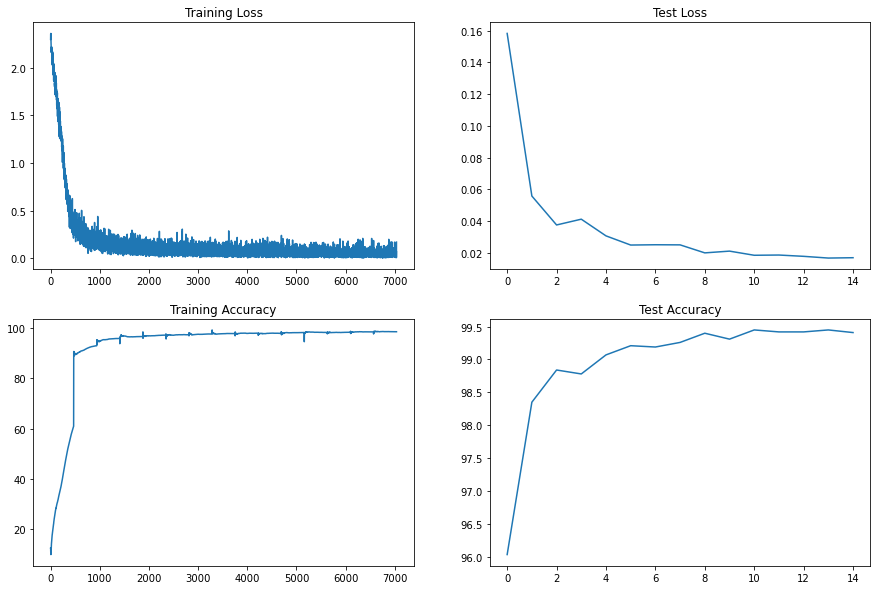

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#### Target:
1. Here, we have added augmentation techniques, RandomAffine and also ColorJitter, so that we can improve the variance in the learnt data for the model, so that it becomes to robust to any unseen data in the test dataset.
2. Also, we have initialized the weights to the model using kaiming_uniform technique, to get a good and a swift convergence.

#### Results:
Parameters: 7,792
Best Train Accuracy: 98.47
Best Test Accuracy: 99.52% (14th Epoch)

#### Analysis:
1. The addition of all of these augmentation techniques, learning rate schedulers, weight initializers and all the iterations done to reduce the number of parameters has got us to this step, where we are able to get consistent test accuracies and basically a very robust model.(Atleast that's what we feel:-)
2. I know there can be much more improvements that can be done to this model structure, but this is the best we could do for now.
3. For future improvements to reduce the number of parameters in a naive way, we can also merge the batchnorm parameters to conv, by doing batchnorm folding to get a lighter model.
